In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns
# Models
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

In [621]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

In [622]:


# feeders_data = pd.read_csv('/Users/natashabeaneycolverd/Documents/Imperial ML & AI cource 05:2024/Capstone/Solar_Portfolio/Data/EXPORT HourlyData - Feeders.csv')
# Network end data not needed for this project as no substations in this dataset included the sites we have weather data for
# network_end_data = pd.read_csv('/Users/natashabeaneycolverd/Documents/Imperial ML & AI cource 05:2024/Capstone/Solar_Portfolio/EXPORT HourlyData/EXPORT HourlyData - Network Endpoints.csv')
cust_end_data = pd.read_csv('/Users/natashabeaneycolverd/Documents/Imperial ML & AI cource 05:2024/Capstone/Solar_Portfolio/Data/EXPORT HourlyData - Customer Endpoints.csv')

weather_data = pd.read_csv('/Users/natashabeaneycolverd/Documents/Imperial ML & AI cource 05:2024/Capstone/Solar_Portfolio/Data/Weather Data 2014-11-30.csv')

# sub_volt_data = pd.read_csv('/Users/natashabeaneycolverd/Documents/Imperial ML & AI cource 05:2024/Capstone/Solar_Portfolio/EXPORT HourlyData/EXPORT HourlyData - Substation Voltages.csv')


/var/folders/ws/xz4yw3fs2tq7qfd6j4g56gp80000gn/T/ipykernel_22497/3063198004.py:6: DtypeWarning: Columns (5,6,7,8,9,15,16,17,22,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_data = pd.read_csv('/Users/natashabeaneycolverd/Documents/Imperial ML & AI cource 05:2024/Capstone/Solar_Portfolio/Data/Weather Data 2014-11-30.csv')


In [623]:
# Cleaning the unneeded columns from the customer data
customer_end_data_clean = cust_end_data[cust_end_data['Substation'].isin(['YMCA', 'Maple Drive East', 'Forest Road'])]
# customer_end_data_clean['Site Date Time ID'] = customer_end_data_clean['datetime'].astype(str) + customer_end_data_clean['Substation']
customer_end_data_clean = cust_end_data.drop(['Substation_VA_MIN_Filtered', 'Substation_VA_MAX_Filtered',
       'Substation_VB_MIN_Filtered', 'Substation_VB_MAX_Filtered',
       'Substation_VC_MIN_Filtered', 'Substation_VC_MAX_Filtered',
       'Substation_thdVA_MIN_Filtered', 'Substation_thdVA_MAX_Filtered',
       'Substation_thdVB_MIN_Filtered', 'Substation_thdVB_MAX_Filtered',
       'Substation_thdVC_MIN_Filtered', 'Substation_thdVC_MAX_Filtered','thdV_MIN', 'thdV_MIN_Filtered',
       'thdV_MAX', 'thdV_MAX_Filtered', 'thdI_GEN_MIN', 'thdI_GEN_MAX',
       'thdI_IMPORT_MIN', 'thdI_IMPORT_MAX', 'Q_GEN_MIN', 'Q_GEN_MAX',
       'Q_IMPORT_MIN', 'Q_IMPORT_MAX', 'S_GEN_MIN', 'S_GEN_MAX',
       'S_IMPORT_MIN', 'S_IMPORT_MAX','f_min', 'f_max','V_MAX_Rise_vs_VA_MIN_Filtered',
       'V_MAX_Rise_vs_VA_MAX_Filtered', 'V_MAX_Rise_vs_VB_MIN_Filtered',
       'V_MAX_Rise_vs_VB_MAX_Filtered', 'V_MAX_Rise_vs_VC_MIN_Filtered',
       'V_MAX_Rise_vs_VC_MAX_Filtered','V_MIN_Filtered','V_MAX_Filtered','I_GEN_MIN_Filtered','I_GEN_MAX_Filtered', 
       'I_IMPORT_MIN_Filtered', 'I_IMPORT_MAX_Filtered','I_GEN_MIN', 'I_GEN_MAX', 'I_IMPORT_MIN', 'I_IMPORT_MAX','SerialNo', 't_date', 't_time', 'd_y', 'd_m',
       'd_d', 'd_w', 't_h', 't_m', 'V_MIN', 'V_MAX', 'P_GEN_MIN','P_IMPORT_MIN', 'P_IMPORT_MAX'], axis=1)
customer_end_data_clean['Site Date Time ID'] = customer_end_data_clean['datetime'].astype(str) + customer_end_data_clean['Substation']
customer_end_data_clean[customer_end_data_clean['P_GEN_MAX'] < 0 ] = 0


In [692]:
customer_end_data_clean

,Substation,datetime,P_GEN_MAX,Site Date Time ID
0,Forest Road,2013-10-01 12:00:00,2.044,2013-10-01 12:00:00Forest Road
1,Forest Road,2013-10-01 13:00:00,1.068,2013-10-01 13:00:00Forest Road
2,Forest Road,2013-10-01 14:00:00,0.824,2013-10-01 14:00:00Forest Road
3,Forest Road,2013-10-01 15:00:00,0.547,2013-10-01 15:00:00Forest Road
4,Forest Road,2013-10-01 16:00:00,0.267,2013-10-01 16:00:00Forest Road
...,...,...,...,...
52347,YMCA,2014-11-19 11:00:00,0.040,2014-11-19 11:00:00YMCA
52348,YMCA,2014-11-19 12:00:00,0.097,2014-11-19 12:00:00YMCA
52349,YMCA,2014-11-19 13:00:00,0.058,2014-11-19 13:00:00YMCA
52350,YMCA,2014-11-19 14:00:00,0.054,2014-11-19 14:00:00YMCA


In [625]:
def func_dir(d):
    for i in range(17):
        a = ['WNW', 'NW', 'W', 'N', 'WSW', 'NNW', 'NNE', 'SW', 'SSW', 'NE',
       '---', 'ENE', 'SSE', 'S', 'E', 'SE', 'ESE']
        b = [5.11,5.505,4.714,4.324,0.000,	0.390,	5.895,0,3.933, 0.790, 2.752,	3.543,	3.143,2.362, 1.571, 1.181,	1.961]
        d.mask(d == a[i],b[i], inplace=True)
        i = i+1

In [626]:
weather_data_clean = weather_data[weather_data['Site'].isin(['YMCA', 'Maple Drive East', 'Forest Road'])]
weather_data_clean['Date'] = pd.to_datetime(weather_data_clean['Date'],format='%d/%m/%Y' )
weather_data_clean['Time'] = pd.to_datetime(weather_data_clean['Time'])
weather_data_clean['Time'] = weather_data_clean['Time'].dt.time
weather_data_clean['Datetime'] = pd.to_datetime(weather_data_clean['Date'].astype(str) + ' '+ weather_data_clean['Time'].astype(str))
weather_data_clean['Site Date Time ID'] = weather_data_clean['Datetime'].astype(str) + weather_data_clean['Site']
# weather_data_clean = weather_data_clean.drop(['HiTemp', 'LowTemp'])
func_dir(weather_data_clean['WindDir'])
func_dir(weather_data_clean['HiDir'])
weather_data_clean = weather_data_clean.drop(['HiTemp', 'LowTemp'],axis=1)

/var/folders/ws/xz4yw3fs2tq7qfd6j4g56gp80000gn/T/ipykernel_22497/1722883104.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data_clean['Date'] = pd.to_datetime(weather_data_clean['Date'],format='%d/%m/%Y' )
/var/folders/ws/xz4yw3fs2tq7qfd6j4g56gp80000gn/T/ipykernel_22497/1722883104.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  weather_data_clean['Time'] = pd.to_datetime(weather_data_clean['Time'])
/var/folders/ws/xz4yw3fs2tq7qfd6j4g56gp80000gn/T/ipykernel_22497/1722883104.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [ ]:
customer_end_data_clean.columns

In [693]:
weather_data_clean

,Site,Date,Month,Time,Hour,TempOut,OutHum,DewPt,WindSpeed,WindDir,...,InHeat,InEMC,InAirDensity,ET,WindSamp,WindTx,ISSRecept,ArcInt,Datetime,Site Date Time ID
0,YMCA,2014-01-07,1,14:30:00,14,10.6,84,8.0,5,5.11,...,16.3,9.39,0.0739,0.00,385,1,56.3,30,2014-01-07 14:30:00,2014-01-07 14:30:00YMCA
1,YMCA,2014-01-07,1,15:00:00,15,10.7,83,7.9,6,5.11,...,16.2,9.39,0.0740,0.03,702,1,100.0,30,2014-01-07 15:00:00,2014-01-07 15:00:00YMCA
2,YMCA,2014-01-07,1,15:30:00,15,10.7,81,7.6,6,4.714,...,16.1,9.39,0.0740,0.00,703,1,100.0,30,2014-01-07 15:30:00,2014-01-07 15:30:00YMCA
3,YMCA,2014-01-07,1,16:00:00,16,10.4,82,7.4,5,5.505,...,16.1,9.39,0.0741,0.03,702,1,100.0,30,2014-01-07 16:00:00,2014-01-07 16:00:00YMCA
4,YMCA,2014-01-07,1,16:30:00,16,10.3,84,7.7,5,5.11,...,15.8,9.40,0.0742,0.00,703,1,100.0,30,2014-01-07 16:30:00,2014-01-07 16:30:00YMCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45415,Forest Road,2014-11-17,11,10:30:00,10,9.1,91,7.7,0,4.714,...,12.7,11.07,0.0751,0.03,703,1,100.0,30,2014-11-17 10:30:00,2014-11-17 10:30:00Forest Road
45416,Forest Road,2014-11-17,11,11:00:00,11,9.8,89,8.1,0,5.11,...,12.9,11.25,0.0750,0.08,702,1,100.0,30,2014-11-17 11:00:00,2014-11-17 11:00:00Forest Road
45417,Forest Road,2014-11-17,11,11:30:00,11,12,81,8.8,1,5.11,...,13.1,11.25,0.0750,0.00,702,1,100.0,30,2014-11-17 11:30:00,2014-11-17 11:30:00Forest Road
45418,Forest Road,2014-11-17,11,12:00:00,12,12.1,80,8.8,0,4.714,...,13.2,11.25,0.0749,0.15,703,1,100.0,30,2014-11-17 12:00:00,2014-11-17 12:00:00Forest Road


In [627]:
data = pd.merge(weather_data_clean, customer_end_data_clean, on ='Site Date Time ID', how='inner')
data = data.drop(['Site', 'Date', 'Month', 'Time', 'Hour','Substation', 'datetime','Datetime','THSWIndex'], axis=1)
# data = data.dropna(inplace=True)
# the join gets rid of the half hour time measures that are not needed here.


In [694]:
data

,TempOut,OutHum,DewPt,WindSpeed,WindDir,WindRun,HiSpeed,HiDir,WindChill,HeatIndex,...,InHeat,InEMC,InAirDensity,ET,WindSamp,WindTx,ISSRecept,ArcInt,Site Date Time ID,P_GEN_MAX
0,10.7,83.0,7.9,6,5.110,3.0,15,5.110,9.5,10.7,...,16.2,9.39,0.0740,0.03,702,1,100.0,30,2014-01-07 15:00:00YMCA,0.025
1,10.4,82.0,7.4,5,5.505,2.5,14,5.505,9.4,10.4,...,16.1,9.39,0.0741,0.03,702,1,100.0,30,2014-01-07 16:00:00YMCA,0.001
2,8.8,91.0,7.4,2,5.110,1.0,9,4.714,8.8,8.9,...,13.9,9.95,0.0754,0.03,703,1,100.0,30,2014-01-08 09:00:00YMCA,0.019
3,9.8,88.0,7.9,3,4.714,1.5,9,5.505,9.6,9.9,...,14.8,9.95,0.0751,0.05,703,1,100.0,30,2014-01-08 10:00:00YMCA,0.106
4,10.1,87.0,8.0,3,5.110,1.5,10,4.714,9.9,10.2,...,16.8,9.75,0.0746,0.08,703,1,100.0,30,2014-01-08 11:00:00YMCA,0.178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12326,13.8,93.0,12.7,1,5.110,0.5,4,5.110,13.8,13.9,...,19.4,10.60,0.0749,0.00,697,3,100.0,30,2014-10-03 06:00:00Forest Road,0.002
12327,13.9,95.0,13.1,0,0.390,0.0,2,0.390,13.9,14.0,...,19.6,10.75,0.0748,0.00,702,3,100.0,30,2014-10-03 07:00:00Forest Road,0.002
12328,13.9,95.0,13.2,0,5.110,0.0,4,1.961,13.9,14.1,...,19.4,10.75,0.0748,0.00,702,3,100.0,30,2014-10-03 08:00:00Forest Road,0.063
12329,14.2,94.0,13.3,0,3.143,0.0,2,0.390,14.2,14.3,...,19.4,10.75,0.0748,0.03,702,2,100.0,30,2014-10-03 09:00:00Forest Road,0.275


In [ ]:
# data_clean = data.drop(['Site', 'Date', 'Month', 'Time', 'Hour','Datetime','SerialNo', 'Substation', 'datetime',
       # 't_date', 't_time', 'd_y', 'd_m', 'd_d', 'd_w','t_h', 't_m','THSWIndex' ],axis=1)

In [ ]:
# corr_data  = data_clean.drop(['Site Date Time ID'],axis=1)


In [628]:
for i in range(len(data.columns)-1):
    # print(i)
    f = data.drop(['Site Date Time ID'],axis=1)
    e = f.columns
    # print(e[i])
    data[e[i]] = pd.to_numeric(data[e[i]], downcast='integer', errors='coerce')

In [630]:
data = data.dropna()

In [636]:
data_X = data.drop(['Site Date Time ID','P_GEN_MAX'],axis=1)
data_Y = data['P_GEN_MAX']

In [638]:
X_train_val, X_test, y_train_val, y_test = train_test_split(data_X, data_Y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


In [695]:
X_train

,TempOut,OutHum,DewPt,WindSpeed,WindDir,WindRun,HiSpeed,HiDir,WindChill,HeatIndex,...,InHum,InDew,InHeat,InEMC,InAirDensity,ET,WindSamp,WindTx,ISSRecept,ArcInt
6720,10.3,94.0,9.4,7,5.110,3.5,16,5.505,8.8,10.5,...,62,6.7,13.2,11.51,0.0762,0.00,702,1,100.0,30
1017,12.0,64.0,5.4,1,1.571,0.5,7,2.362,12.0,11.4,...,30,5.8,23.8,6.05,0.0730,0.23,702,1,100.0,30
9499,11.2,79.0,7.7,0,2.752,0.0,0,2.752,11.2,11.0,...,46,5.7,16.2,8.71,0.0751,0.03,702,5,100.0,30
9680,22.3,53.0,12.2,0,3.143,0.0,3,2.362,22.3,21.9,...,42,12.1,25.7,7.87,0.0731,0.08,702,4,100.0,30
1972,19.0,48.0,7.7,1,2.362,0.5,6,4.714,19.0,18.0,...,24,9.9,31.8,4.95,0.0708,0.00,702,1,100.0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2942,18.8,63.0,11.6,1,5.895,0.5,7,0.790,18.8,18.6,...,36,12.8,29.1,6.75,0.0715,0.15,702,1,100.0,30
826,6.2,97.0,5.7,1,0.000,0.5,5,0.000,6.2,6.3,...,47,3.3,13.2,8.95,0.0755,0.05,703,1,100.0,30
6953,5.6,85.0,3.3,3,5.110,1.5,9,5.110,4.8,5.5,...,55,1.9,9.9,10.27,0.0748,0.05,703,1,100.0,30
5762,19.2,63.0,12.0,0,3.143,0.0,2,3.143,19.2,19.0,...,32,8.6,25.6,6.35,0.0725,0.03,702,1,100.0,30


In [ ]:
neg_y = list(filter(lambda x: (x < 0), data_Y))
pos_y = list(filter(lambda x: (x > 0), data_Y))

Correlation Matrix:
               TempOut    OutHum     DewPt  WindSpeed   WindDir   WindRun  \
TempOut       1.000000 -0.620294  0.784198  -0.135100 -0.055426 -0.135100   
OutHum       -0.620294  1.000000 -0.006175  -0.065973 -0.027602 -0.065973   
DewPt         0.784198 -0.006175  1.000000  -0.223152 -0.089563 -0.223152   
WindSpeed    -0.135100 -0.065973 -0.223152   1.000000  0.214382  1.000000   
WindDir      -0.055426 -0.027602 -0.089563   0.214382  1.000000  0.214382   
WindRun      -0.135100 -0.065973 -0.223152   1.000000  0.214382  1.000000   
HiSpeed      -0.061258 -0.145501 -0.188551   0.925944  0.221240  0.925944   
HiDir        -0.035240  0.006043 -0.041692   0.060754  0.466484  0.060754   
WindChill     0.996527 -0.614916  0.784215  -0.196872 -0.065985 -0.196872   
HeatIndex     0.997225 -0.569637  0.820843  -0.144862 -0.058509 -0.144862   
THWIndex      0.994271 -0.566289  0.819902  -0.206174 -0.068967 -0.206174   
Bar           0.267477 -0.242303  0.156016  -0.439664 -0

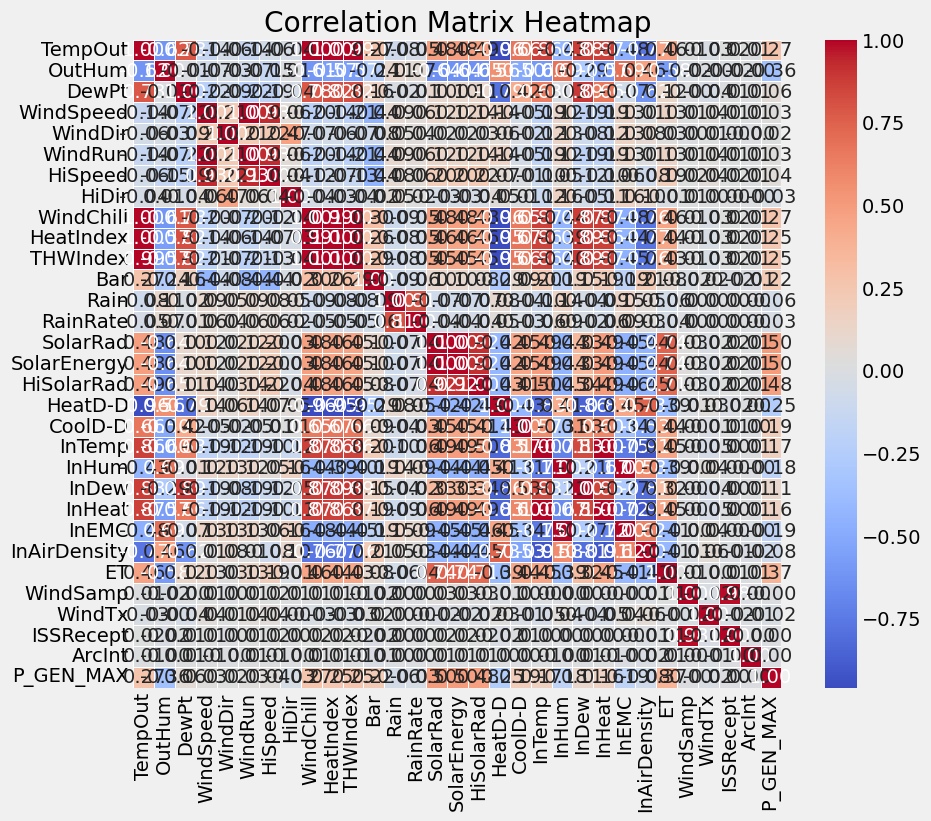

In [639]:
correlation_matrix = f.corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


In [ ]:
def plot(i):
    
    a = corr_data.columns

    plt.xlabel(rf'Column {a[i]} ')
    plt.hist(corr_data[a[i]])
    # plt.plot(Xsamp, ysamp)
    plt.show()

In [ ]:
def hist_box():
    a = corr_data.columns
    num_cols = corr_data.select_dtypes(include=np.number).columns.tolist()
    for col in num_cols:
        print(col)
        print('Skew :', round(corr_data[col].skew(), 2))
        plt.figure(figsize = (15, 4))
        plt.subplot(1, 2, 1)
        corr_data[col].hist(grid=False)
        plt.ylabel('count')
        plt.subplot(1, 2, 2)
        sns.boxplot(x=corr_data[col])
        plt.show()


Section the data

In [ ]:
# trainsize = int(len(data)/2)
# trainplusvalsize = int(len(data)/4)
# X_train=data_X[:trainsize]
# X_val=data_X[trainsize:trainsize + trainplusvalsize]
# X_test=data_X[trainsize + trainplusvalsize:]

# y_train=data_Y[:trainsize]
# y_val=data_Y[trainsize:trainsize + trainplusvalsize]
# y_test=data_Y[trainsize + trainplusvalsize:]

Model Sellection 

PCA - dimension reduction

In [696]:
# Standardise the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
# Fit the PCA
pca = PCA(n_components=11)

X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

kpca_linear = KernelPCA(n_components = 15, kernel = "linear",fit_inverse_transform=True)
kpca_rbf = KernelPCA(n_components = 11, kernel = "rbf",fit_inverse_transform=True)
kpca_poly = KernelPCA(n_components= 11, kernel= "poly",fit_inverse_transform=True)
kpca_cos = KernelPCA(n_components= 11, kernel= "cosine",fit_inverse_transform=True)



In [700]:
X_train_lin = kpca_linear.fit_transform(X_train_scaled)
# X_train_rbf = kpca_rbf.fit_transform(X_train_scaled)
# X_train_poly = kpca_poly.fit_transform(X_train_scaled)
# X_train_cos = kpca_cos.fit_transform(X_train_scaled)

In [697]:
pca_data_reconstructed = pca.inverse_transform(X_train_pca)
reconstruction_error = mean_squared_error(X_train_scaled, pca_data_reconstructed)
print("PCA Reconstruction error:", reconstruction_error)

# x_lin_data_reconstructed = kpca_linear.inverse_transform(X_train_lin)
# reconstruction_error = mean_squared_error(X_train_scaled, x_lin_data_reconstructed)
# print("PCA Reconstruction error:", reconstruction_error)

# xrbf_data_reconstructed = kpca_rbf.inverse_transform(X_train_rbf)
# reconstruction_error = mean_squared_error(X_train_scaled, xrbf_data_reconstructed)
# print("PCA Reconstruction error:", reconstruction_error)

# xpoly_data_reconstructed = kpca_poly.inverse_transform(X_train_poly)
# reconstruction_error = mean_squared_error(X_train_scaled, xpoly_data_reconstructed)
# print("PCA Reconstruction error:", reconstruction_error)


# xcos_data_reconstructed = kpca_cos.inverse_transform(X_train_cos)
# reconstruction_error = mean_squared_error(X_train_scaled, xcos_data_reconstructed)
# print("PCA Reconstruction error:", reconstruction_error)



PCA Reconstruction error: 0.04563037875249542


Lower the reconstruction error rate the better. PCA and PCAKernal linear identical show this is a linear problem 

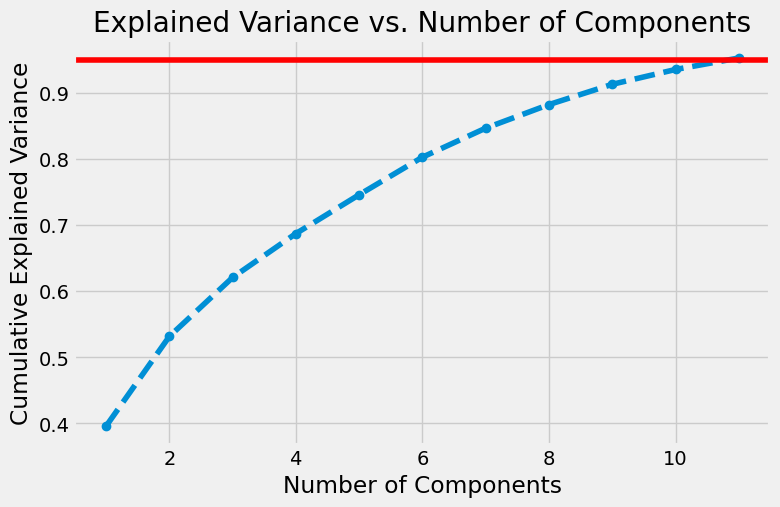

Number of components to retain 95% variance: 11


In [701]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot cumulative variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.axhline(y=0.95, color='r', linestyle='-')
# plt.axvline(x=14,color='r', linestyle='-')
plt.show()

# Find the number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components_95}")

Correlation Matrix:


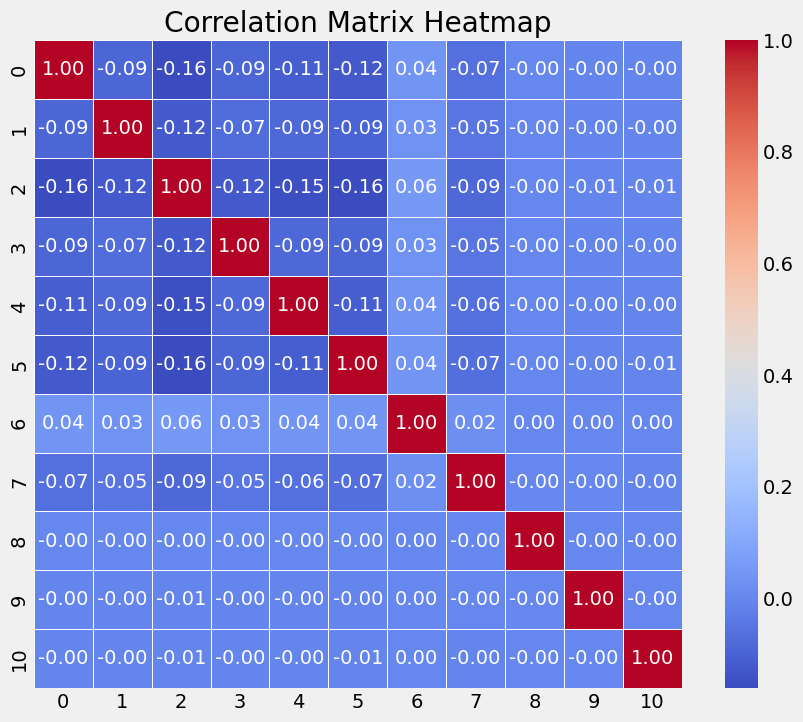

In [648]:
components = pca.components_

# Compute correlation matrix

correlation_matrix = np.corrcoef(components)
# print("Correlation matrix of principal components:\n", correlation_matrix)



# Print the correlation matrix
print("Correlation Matrix:")
# print(correlation_matrix)

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Values close to zero show orthogonality 

K Nearest Neighbour

In [ ]:
from sklearn import neighbors

from math import sqrt

In [ ]:
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train_pca, y_train)  #fit the model
    pred=model.predict(X_val_pca) #make prediction on test set
    error = sqrt(mean_squared_error(y_val,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.5142260233417928
RMSE value for k=  2 is: 0.4608187429218365
RMSE value for k=  3 is: 0.44350845226329205
RMSE value for k=  4 is: 0.4372423742980458
RMSE value for k=  5 is: 0.43349868368787936
RMSE value for k=  6 is: 0.42917659657748497
RMSE value for k=  7 is: 0.42890425908039786
RMSE value for k=  8 is: 0.4269110805382476
RMSE value for k=  9 is: 0.42591817297855844
RMSE value for k=  10 is: 0.4238265197223403
RMSE value for k=  11 is: 0.42351593873226495
RMSE value for k=  12 is: 0.4225786049440894
RMSE value for k=  13 is: 0.4218601959374427
RMSE value for k=  14 is: 0.4206341516274781
RMSE value for k=  15 is: 0.4186556108837741
RMSE value for k=  16 is: 0.41768555306797434
RMSE value for k=  17 is: 0.4187258269704934
RMSE value for k=  18 is: 0.41800789534436333
RMSE value for k=  19 is: 0.4192413456013822
RMSE value for k=  20 is: 0.42062555574740135


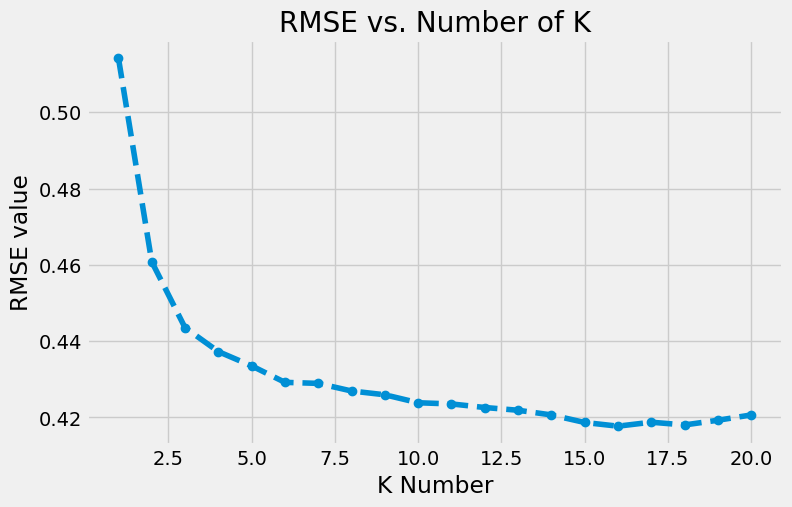

In [706]:
# Plot cumulative variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, 21), rmse_val, marker='o', linestyle='--')
plt.xlabel('K Number')
plt.ylabel('RMSE value')
plt.title('RMSE vs. Number of K')
# plt.axhline(y=0.95, color='r', linestyle='-')
# plt.axvline(x=14,color='r', linestyle='-')
plt.show()

# Find the number of components for 95% variance
# n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
# print(f"Number of components to retain 95% variance: {n_components_95}")

k = 6 looks best

RMSE value: 0.40980405397552083


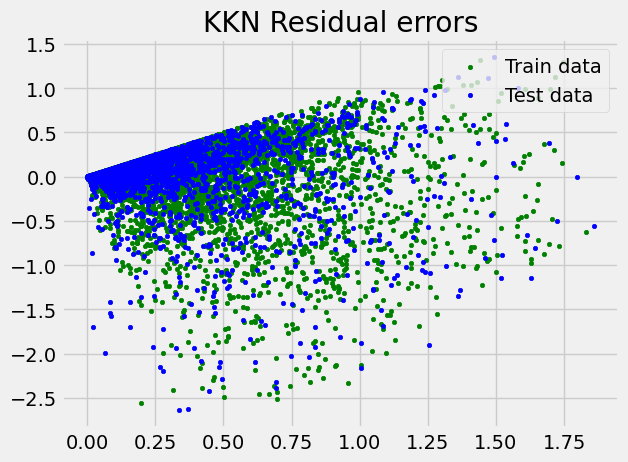

In [713]:
plt.style.use('fivethirtyeight')
rmse_knn = []
model = neighbors.KNeighborsRegressor(n_neighbors = 15)
model.fit(X_train_pca, y_train) 
pred=model.predict(X_test_pca)
error = sqrt(mean_squared_error(y_test, pred))
rmse_val.append(error)
print('RMSE value:', error)
# plotting residual errors in training data
plt.scatter(model.predict(X_train_pca),
            model.predict(X_train_pca) - y_train,
            color="green", s=10,
            label='Train data')

# plotting residual errors in test data
plt.scatter(model.predict(X_test_pca),
            model.predict(X_test_pca) - y_test,
            color="blue", s=10,
            label='Test data')

# plotting line for zero residual error
# plt.hlines(y=0, xmin=0, xmax=50, linewidth=2)

# plotting legend
plt.legend(loc='upper right')

# plot title
plt.title("KKN Residual errors")

# method call for showing the plot
plt.show()

<Axes: >

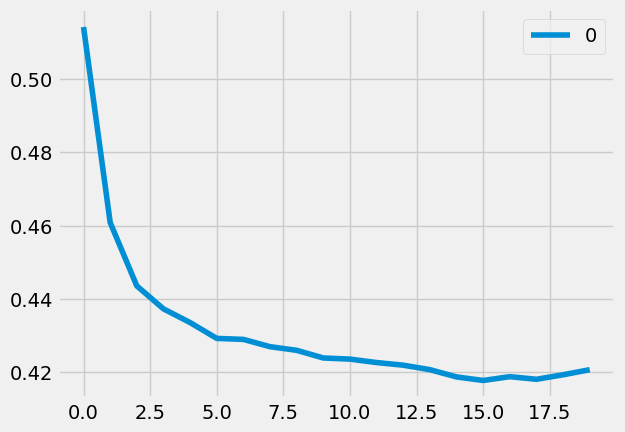

In [709]:
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

Linear Regression 

In [652]:
from sklearn import linear_model

In [654]:
rmse_val_a = []
reg = linear_model.LinearRegression()
reg.fit(X_train_pca, y_train)
pred=reg.predict(X_test_pca)
error = sqrt(mean_squared_error(y_test, pred))
rmse_val_a.append(error)
print('RMSE value:', error)


RMSE value: 0.4318868837984686


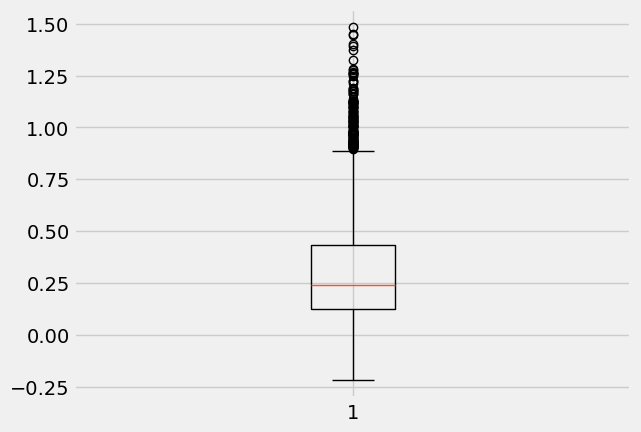

In [655]:
plt.boxplot(pred)
plt.show()

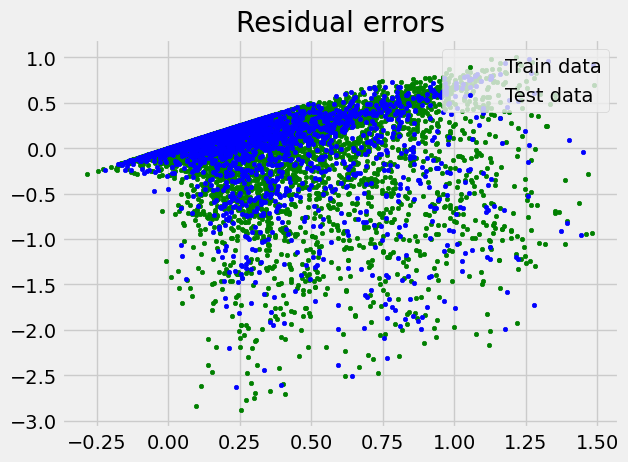

In [656]:
plt.style.use('fivethirtyeight')

# plotting residual errors in training data
plt.scatter(reg.predict(X_train_pca),
            reg.predict(X_train_pca) - y_train,
            color="green", s=10,
            label='Train data')

# plotting residual errors in test data
plt.scatter(reg.predict(X_test_pca),
            reg.predict(X_test_pca) - y_test,
            color="blue", s=10,
            label='Test data')

# plotting line for zero residual error
# plt.hlines(y=0, xmin=0, xmax=50, linewidth=2)

# plotting legend
plt.legend(loc='upper right')

# plot title
plt.title("Residual errors")

# method call for showing the plot
plt.show()

In [658]:
reg_non = linear_model.LinearRegression()
rmse_b = []
reg_non.fit(X_train, y_train)
pred_a=reg_non.predict(X_test)
error_a = sqrt(mean_squared_error(y_test, pred_a))
rmse_b.append(error)
print('RMSE value:', error_a)

RMSE value: 0.42332670286869795


linear regression with PCA gives a RMSE value: 0.42527019083809003 which is simular to knn but predicts values that are negative which is not possible 

explore the use of a generalised linear model such as gamma regression model or log-link linear model 

Decision Tree models on data with PCA 

Random Forest 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [715]:
rf_reg = RandomForestRegressor(random_state=0,bootstrap= False, max_depth = 20, max_features ='sqrt', n_estimators= 300)
# rf_reg2 = RandomForestRegressor(random_state=0)
rf = rf_reg.fit(X_train, y_train)
# rf_pca = rf_reg2.fit(X_train_pca, y_train)

In [680]:
pred_rf = rf.predict(X_test)
# pred_rf_pca = rf_pca.predict(X_test_pca)


In [681]:
mse = mean_squared_error(y_test, pred_rf)
# mse_pca = mean_squared_error(y_test, pred_rf_pca)
error = sqrt(mean_squared_error(y_test, pred_rf))
# error_pca = sqrt(mean_squared_error(y_test, pred_rf_pca))

In [682]:
print('Rf tree mse:', mse)
# print('PCA RF tree mse:' ,mse_pca)

Rf tree mse: 0.12133682900299228


In [684]:
print ( 'Full tree guess train/validation ',rf.score(X_train, y_train),rf.score(X_test, y_test))
# print('PCA tree train test socre: ', rf_pca.score(X_train_pca,y_train), rf_pca.score(X_test_pca, y_test))
print('RMSE rf ', error)
# print('RMSE PCA ', error_pca)


Full tree guess train/validation  0.9992280572579255 0.5632968463237076
RMSE rf  0.3483343637986242


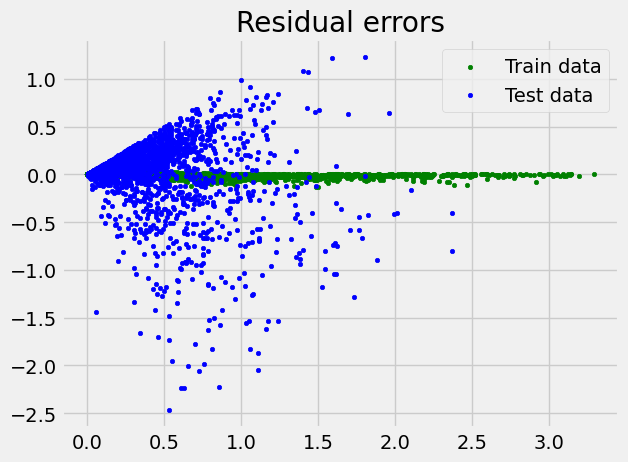

In [716]:
plt.style.use('fivethirtyeight')

# plotting residual errors in training data
plt.scatter(rf.predict(X_train),
            rf.predict(X_train) - y_train,
            color="green", s=10,
            label='Train data')

# plotting residual errors in test data
plt.scatter(rf.predict(X_test),
            rf.predict(X_test) - y_test,
            color="blue", s=10,
            label='Test data')

# plotting line for zero residual error
# plt.hlines(y=0, xmin=0, xmax=50, linewidth=2)

# plotting legend
plt.legend(loc='upper right')

# plot title
plt.title("Residual errors")

# method call for showing the plot
plt.show()

In [717]:
pred = rf.predict(X_val)
error = sqrt(mean_squared_error(y_val, pred))
print(error)


0.35239628296005376


In [670]:
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
ab_reg = AdaBoostRegressor()
ab = ab_reg.fit(X_train, y_train)

In [674]:
pred_ab = ab.predict(X_test)
error_ab = sqrt(mean_squared_error(y_test, pred_ab))


In [676]:
print('rmse ab boosting error', error_ab)

rmse ab boosting error 0.4633418877387479


In [665]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

In [688]:
feature_importances = rf_reg.feature_importances_
sorted_idx = feature_importances.argsort()
feature_names = X_train.columns

In [689]:
def plot_impurity_metric_features( feature_importances, sorted_idx, feature_names):
    y_ticks = np.arange(0, len(feature_names))
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.barh(y_ticks, feature_importances[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_title("Random Forest Feature Importances (MDI)")
    fig.tight_layout()
    plt.show()



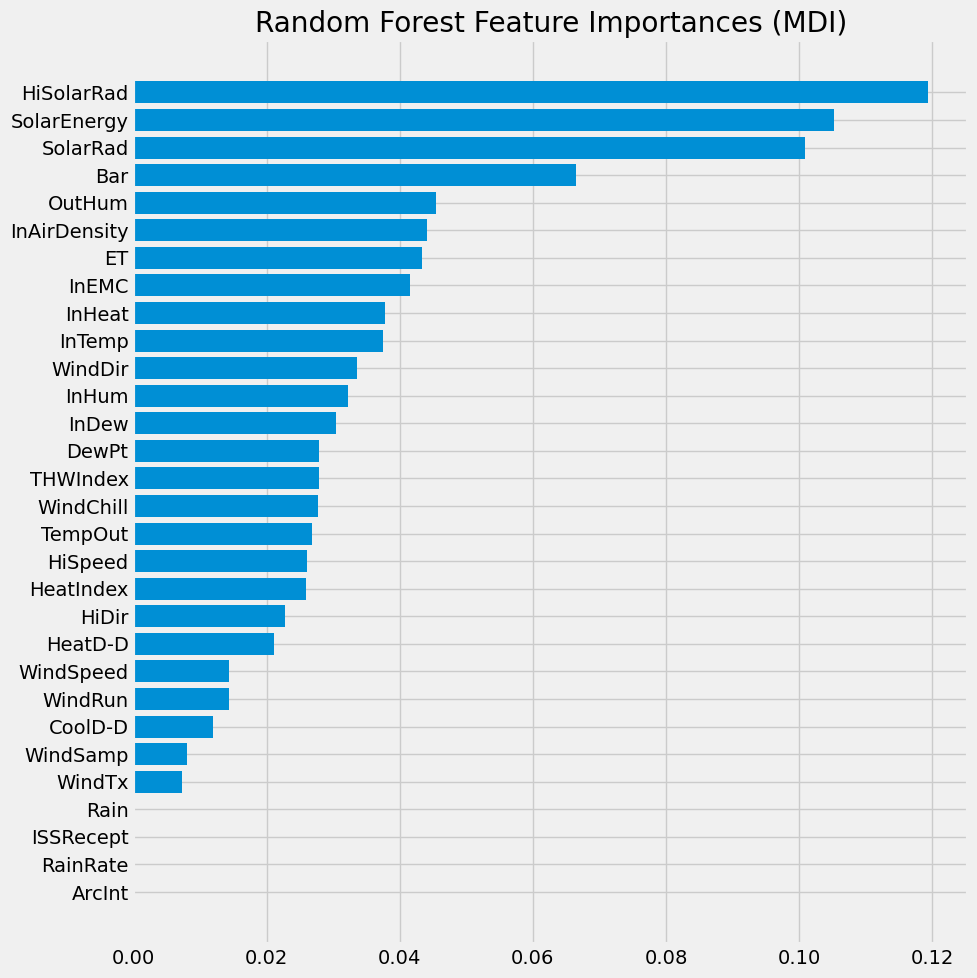

In [690]:

plot_impurity_metric_features( feature_importances, sorted_idx, feature_names)

In [678]:
param_grid = {
    
    'n_estimators': [100, 200, 300],       # Number of trees
    # 
    'max_depth': [10, 20, 30, None],           # Tree depth, with None allowing full growth
    # 'min_samples_split': [2, 5, 10],           # Min samples to split a node
    # 'min_samples_leaf': [1, 2, 4],             # Min samples at a leaf node
    'max_features': ['sqrt', 'log2', None],    # Number of features to consider for the best split
    'bootstrap': [True, False],                # Whether to bootstrap samples
}


grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best parameters
# print(grid_search.best_params_)
# Best parameters
print("Best parameters found:", grid_search.best_params_)

# Best model
best_model = grid_search.best_estimator_

# Evaluate on the test set
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Test RMSE: {rmse}")

Best parameters found: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 300}
Test RMSE: 0.34727714803554227


In [ ]:
plt.style.use('fivethirtyeight')

# plotting residual errors in training data
plt.scatter(reg.predict(X_train_pca),
            reg.predict(X_train_pca) - y_train,
            color="green", s=10,
            label='Train data')

# plotting residual errors in test data
plt.scatter(reg.predict(X_test_pca),
            reg.predict(X_test_pca) - y_test,
            color="blue", s=10,
            label='Test data')

# plotting line for zero residual error
# plt.hlines(y=0, xmin=0, xmax=50, linewidth=2)

# plotting legend
plt.legend(loc='upper right')

# plot title
plt.title("Residual errors")

# method call for showing the plot
plt.show()

Best parameters found: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 300}
Test RMSE: 0.34727714803554227